# Определение фейковых новостей

## Подготовка модулей и импорт данных

Импортируем необходимые для работы модули:

In [1]:
# Базовые библиотеки + настройки
import pandas as pd
import numpy as np
from collections import Counter
import warnings
import time
import itertools

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

# Визуализация и параметры визуализации
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pylab import rcParams

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
rcParams["figure.figsize"] = 10, 5
plt.rcParams.update({'font.weight': 500})

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# NLP модули
import nltk
from pymystem3 import Mystem
import pymorphy2

# Моделирование
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer
)
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier
)
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    cross_val_score, 
    StratifiedKFold
)
from sklearn.metrics import (
    precision_score, 
    recall_score,
    f1_score,
    accuracy_score
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Импортируем данные:

In [2]:
df_train = pd.read_csv(r'dataset/train.tsv', sep = '\t')
df_test = pd.read_csv(r'dataset/test.tsv', sep = '\t')

## Первичный анализ данных

В рамках первичного анализа сразу видим, что 
- тренировочная выборка содержит ок 6 тыс. наблюдений и, что приятно, сбалансирована по классам: соотношение фейков к нормальным новостям составляет 50/50
- тестовая выборка содержит 1 тыс. значений
- пропусков (nulls) в данных нет.

In [3]:
print('Тренировочный файл')
df_train.info()
print('\nРазбивка на фейк/не фейк:\n', df_train['is_fake'].value_counts(normalize = True))
print('\n\nТестовый файл')
df_test.info()

Тренировочный файл
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB

Разбивка на фейк/не фейк:
 1    0.5
0    0.5
Name: is_fake, dtype: float64


Тестовый файл
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Как это всегда бывает в NLP-задачах, первичные данные необходимо отформатировать перед обучением модели: в строках присутствуют знаки препинания, разные формы однокоренных слов, заглавные буквы и пр.

In [4]:
df_train.head()

title  \
0  Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы   
1                      Агент Кокорина назвал езду по встречке житейской историей   
2    Госдума рассмотрит возможность введения секретных статей Уголовного кодекса   
3                      ФАС заблокировала поставку скоростных трамваев для Москвы   
4                    Против Навального завели дело о недоносительстве на Волкова   

   is_fake  
0        1  
1        0  
2        1  
3        0  
4        1

In [5]:
df_test.tail()

title  \
995              Прокуратура заподозрила Явлинского в авторитарном стиле управления партией   
996  В День Победы стратегические ракетоносцы Ту-160 дадут боевой залп над Красной площадью   
997              СК возбудил дело против авиакомпании «Победа» за финансирование Навального   
998                           Криптомонетный двор Туркменистана выпустил юбилейные биткоины   
999                      Deutsche Bahn заплатит рекордный штраф за чтение писем сотрудников   

     is_fake  
995        0  
996        0  
997        0  
998        0  
999        0

## Проверка предположений

Проверим, отличаются ли настоящие и фейковые новости по:
1. Длине заголовка. Гипотеза - фейковые заголовки короче, т. к. их легче придумать и они легче воспринимаются.
2. Упоминаниям имен собственных. Гипотеза - имена собственные чаще используются в фейковых заголовках.
3. Эмоциональному окрасу заголовков (есть знаки ! и ?). Гипотеза - эмоции больше свойственны фейковым новостям.
4. Наличию цифр. Гипотеза - конкретные цифры чаще встречаются в фейковых заголовках, чтобы привлечь читателя.
5. Наличию иностранных слов (которых в тренировочной выборке ок. 5%). Гипотеза - иностранные слова чаще используются в реальных заголовках, т. к. не все их понимают.
6. Наличию прямых цитат. Гипотеза - прямые цитаты часто используются в фейковых заголовках.

Для реализации данных задач подготовим необходимые паттерны и функцию для поиска регулярных выражений.

In [6]:
#import re
import regex as re

# Проверка на ? и ! в предложении
emotion = re.compile(r'[?!]')
# Проверка на наличие цифр в предложении
number = re.compile(r'\d')
# Проверка на имя собственное - внутри предложения пишется с большой буквы
upper = re.compile(r'.\s[A-ZА-Я][a-zа-я]+')
# Проверка на имя собственное из двух слов и более внутри заголовка
upper_2 = re.compile(r'.\s[A-ZА-Я][a-zа-я]+\s[A-ZА-Я]')
# Проверка на букву не на кириллице
foreign = re.compile(r'(?=\w)(?=[^\u0400-\u04FF_])(?=\D)')
# Проверка на наличие цитат
citing = re.compile(r'["“”«»]') # Проверка на цитаты

Пропишем функцию для поиска регулярных выражений в тексте.

In [7]:
def has_pattern(text, pattern):
    ''' Функция проверяет наличие паттернов в тексте (1-есть, 0-нет)'''
    if bool(re.search(pattern, text)):
        return(1)
    return(0)

Добавим новые атрибуты признаки в таблицу df_train, воспользовавшись функцией выше. Также добавим новый столбец с числом слов, начинающихся с большой буквы (включая начало предложения) и с общей длиной заголовка.

In [8]:
def add_cols(df):
    df['length'] = df['title'].apply(lambda x: len(x)) # Посимвольная длина показывает лучше результат, чем пословная
    df['emotion'] = df['title'].apply(lambda x: has_pattern(x, emotion))
    df['number'] = df['title'].apply(lambda x: has_pattern(x, number))
    df['foreign'] = df['title'].apply(lambda x: has_pattern(x, foreign))
    df['citing'] = df['title'].apply(lambda x: has_pattern(x, citing))
    df['upper_count'] = df['title'].str.findall(r'.\s[A-ZА-Я][a-zа-я]').str.len()

# Редактируем тестовую и тренировочную выборки
add_cols(df_train)
add_cols(df_test)

Визуализируем на графиках значения новых признаков.

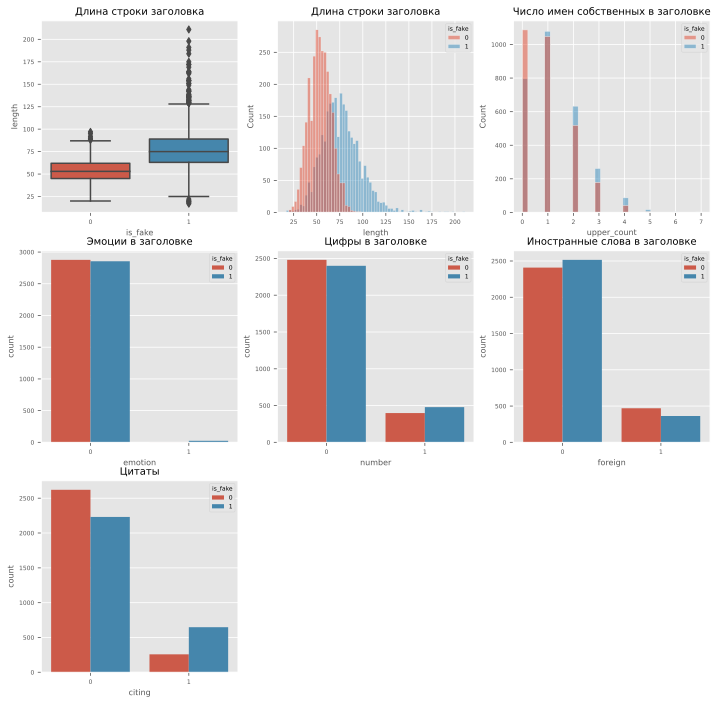

In [9]:
fig = plt.figure(figsize=(12, 12), dpi=800)
ax1 =fig.add_subplot(3,3,1)
sns.boxplot(ax=ax1, x = 'is_fake', y = 'length', data = df_train)
ax1.set_title('Длина строки заголовка')

ax2 =fig.add_subplot(3,3,2)
sns.histplot(ax=ax2, x = 'length', hue = 'is_fake', data = df_train)
ax2.set_title('Длина строки заголовка')

ax3 =fig.add_subplot(3,3,4)
sns.countplot(ax=ax3, x='emotion', hue='is_fake', data=df_train)
ax3.set_title('Эмоции в заголовке')

ax4 =fig.add_subplot(3,3,3)
sns.histplot(ax = ax4, x = 'upper_count', hue = 'is_fake', data = df_train)
ax4.set_title('Число имен собственных в заголовке')

ax5 =fig.add_subplot(3,3,5)
sns.countplot(ax=ax5, x='number', hue='is_fake', data=df_train)
ax5.set_title('Цифры в заголовке')

ax6 =fig.add_subplot(3,3,6)
sns.countplot(ax = ax6, x='foreign', hue='is_fake', data=df_train)
ax6.set_title('Иностранные слова в заголовке')

ax7 =fig.add_subplot(3,3,7)
sns.countplot(ax = ax7, x='citing', hue='is_fake', data=df_train)
ax7.set_title('Цитаты');

Пройдемся еще раз по нашим гипотезам, глядя на графики:

1. Длина заголовка. Гипотеза - фейковые заголовки короче, т. к. их легче придумать и они легче воспринимаются.
<br>*Верно обратное. На гистограмме очень хорошо видно, что фейковые новости в среднем длиннее, чем нормальные.*

2. Упоминания имен собственных. Гипотеза - имена собственные чаще используются в фейковых заголовках.
<br>*Верно. Чем больше имен собственных, тем более "фейковой" становится новость.*

3. Эмоциональный окрас заголовков (есть знаки ! и ?). Гипотеза - эмоции больше свойственны фейковым новостям.
<br>*Верно. Хотя эмоциональный окрас встретился лишь в 26 заголовках, 92% из них оказались фейками.*

4. Наличие цифр. Гипотеза - конкретные цифры чаще встречаются в фейковых заголовках, чтобы привлечь читателя
<br>*Верно. Цифры чаще встречаются в правильных заголовках (отношение 55/45 к фейкам).*

5. Наличие иностранных слов (которых в тренировочной выборке ок. 5%). Гипотеза - иностранные слова чаще используются в реальных заголовках, т. к. не все их понимают.
<br>*Верно. Иностранные слова встречаются редко, фейковых заголовков с иностранными словами на 20% меньше, чем обычных.*

6. Наличие прямых цитат. Гипотеза - прямые цитаты часто используются в фейковых заголовках.
<br>*Верно. Цитирование правдо гораздо чаще встречается у фейковых новостей.*







In [10]:
print('Заголовки с эмоциями:\n', 
      df_train[df_train['emotion'] == 1]['is_fake'].value_counts())
print('\nЗаголовки с иностранными словами:\n', 
      df_train[df_train['foreign'] == 1]['is_fake'].value_counts(normalize=True))
print('\nЗаголовки с номерами:\n', 
      df_train[df_train['number'] == 1]['is_fake'].value_counts(normalize=True))

Заголовки с эмоциями:
 1    24
0     2
Name: is_fake, dtype: int64

Заголовки с иностранными словами:
 0    0.564226
1    0.435774
Name: is_fake, dtype: float64

Заголовки с номерами:
 1    0.54618
0    0.45382
Name: is_fake, dtype: float64


**Т.к. значения по выявленным признакам различаются для фейковых и обычных заголовков, нужно будет добавить некоторые из признаков в модели, чтобы улучшить их качество.**

## Подготовка данных (старт)

Завершив поверхностное изучение наших данных, можно приступать к трансформации корпуса под моделирование:
1. Избавиться от знаков препинания
2. Перевести в слова единый (нижний) регистр
3. Убрать стоп-слова: предлоги и слова, не несущие смысла (например, предлоги)
4. Привести однокоренные слова в единообразный вид - для русского языка лучше использовать лемматизацию, а не стемминг
5. Провести векторизацию заголовков.

Избавимся от знаков препинания и переведем в нижний регистр

In [11]:
def del_punctuation(text):
    ''' Удаляет пунктуацию в тексте, кроме дефисов '''
    clean_text = re.sub('[”“«»!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~]', '', text)
    clean_text = re.sub('-\s', ' ', clean_text)
    return(clean_text)

def del_punctuation_in_df(df):
    ''' Создает столбец с заголовком без пунктуации в датафрейме '''
    df['clean_title'] = df['title'].apply(lambda x: x.lower()) # нижний регистр
    df['clean_title'] = df['clean_title'].str.replace('\d+', '') # удаляем цифры
    df['clean_title'] = df['clean_title'].str.replace('ё', 'е') # заменяем ё на е
    df['clean_title'] = df['clean_title'].apply(lambda x: del_punctuation(x)) # удаляем пунктуацию, кроме дефисов

del_punctuation_in_df(df_train)
del_punctuation_in_df(df_test)

df_train[['title', 'clean_title']].tail()

title  \
5753                               Эдди Чемберс получил сотрясение мозга в бою с Кличко   
5754                               Правительство застроит Россию нефтепродуктопроводами   
5755  «Мне стыдно перед дедом»: новый канцлер ФРГ обратился с первой речью к Бундестагу   
5756                                   Туркмения в декабре начнет поставки газа в Китай   
5757                             Бывший тренер Локомотива возглавил нальчикский Спартак   

                                                                         clean_title  
5753                            эдди чемберс получил сотрясение мозга в бою с кличко  
5754                            правительство застроит россию нефтепродуктопроводами  
5755  мне стыдно перед дедом новый канцлер фрг обратился с первой речью к бундестагу  
5756                                туркмения в декабре начнет поставки газа в китай  
5757                          бывший тренер локомотива возглавил нальчикский спартак

Пока мы не удалили стоп-слова и провели лемматизацию корпуса прервемся на проведение морфологического разбора заголовков.

## Морфологический анализ

Будем использовать для морфологического анализа модуль от Яндекса Mystem3. Начнем с функции, которая определяет часть речи для слова.

In [12]:
morph_pymystem3 = Mystem()

def mystem_analyze(text):
    ''' Определяет часть речи для слова '''
    try:
        res = morph_pymystem3.analyze(text = text)[0]['analysis'][0]['gr']
        res = re.split(r'[,=]', res)[0]
        return(res)
    except:
        return('NA')

С сайта проекта Mystem3 позаимствуем словарь для расшифровки частей речи.

In [13]:
mapping_dict = {'A':'прилагательное', 
                'ADV':'наречие', 
                'ADVPRO':'местоименное наречие', 
                'ANUM':'числительное-прилагательное', 
                'APRO':'местоимение-прилагательное', 
                'COM': 'часть композита - сложного слова',
                'CONJ':'союз',
                'INTJ':'междометие',
                'NUM':'числительное',
                'PART':'частица',
                'PR':'предлог',
                'S':'существительное',
                'SPRO':'местоимение-существительное',
                'V':'глагол',
                'NA':'NA'
                }

Закончим тем, что построим диаграмму частотности каждой из частей речи. 
<br> На графиках видно, что во всех типах заголовков преобладают существительные. В фейковых заголовках немного немного больше доля прилагательных, в правдивых - слов с типом NA - сюда попали в основном иностранные слова, которые mystem3 не понимает. **Таким образом, делаем вывод, что морфологическая структура настоящих и фейковых заголовков в целом сопоставима**. 

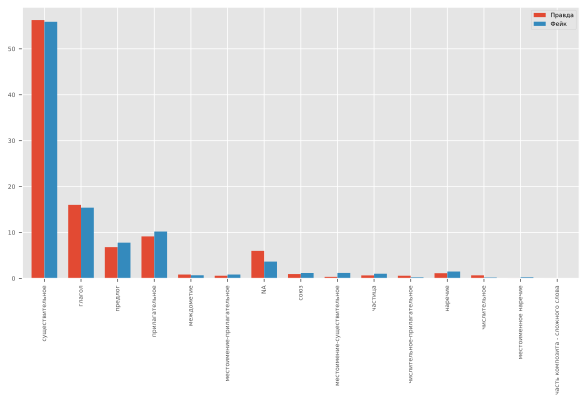

In [14]:
# Все слова в фейковых/не фейковых заголовках отправляем в соответствующие списки
all_tokenized_ok = ' '.join(df_train[df_train['is_fake']==0]['clean_title'].tolist())
all_tokenized_ok = all_tokenized_ok.split(sep = ' ')
all_tokenized_fake = ' '.join(df_train[df_train['is_fake']==1]['clean_title'].tolist())
all_tokenized_fake = all_tokenized_fake.split(sep = ' ')

def get_post_tags_list(tokenized_articles):
    ''' Определяет часть речи для слова, используя функцию mystem_analyze() и словарь, приведенные выше '''
    all_pos_tags = []
    for word in tokenized_articles:
        pos_tag = mystem_analyze(word)
        all_pos_tags.append(mapping_dict[pos_tag])
    return(all_pos_tags)

all_pos_tagged_word_gen = get_post_tags_list(all_tokenized_ok)
all_pos_tagged_word_fake = get_post_tags_list(all_tokenized_fake)

gen_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_gen)).items(), columns=['Pos_tag', 'Правда'])
fake_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_fake)).items(), columns=['Pos_tag', 'Фейк'])
pos_df = gen_pos_df.merge(fake_pos_df, on='Pos_tag')

# Найдем процентное соотношение для сопоставимости
pos_df['Правда'] = pos_df['Правда'] * 100 / pos_df['Правда'].sum()
pos_df['Фейк'] = pos_df['Фейк'] * 100 / pos_df['Фейк'].sum()
pos_df.head()

# Нарисуем графики
pos_df.plot.bar(width=0.7)
plt.xticks(range(0,len(pos_df['Pos_tag'])), pos_df['Pos_tag'])
plt.rcParams["figure.figsize"] = (12,6);

## Подготовка данных (продолжение)

Вернемся к трансформации данных. Избавимся от стоп-слов с помощью списка стоп-слов от NLTK:

In [15]:
nltk.download('stopwords')
stopwords_nltk = nltk.corpus.stopwords.words(['russian'])
print(stopwords_nltk)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemkuznetsov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ряд стоп-слов от NLTK в действительности может существенно повлиять на смысл или интонацию заголовка. Например, отрицательные частицы и междометия. К тому же, из морфологического анализа слов мы увидели, что местоимения и наречия чаще встречаются в фейках. Поэтому было решено стоп-слова удалять по-минимуму - только простые предлоги.

In [16]:
# Зададим стоп-слова вручную
customized_stopwords = (['до', 'со', 'о', 'с', 'при', 'через', 'для', 'на', 'из', 'другой', 'от', 'по', 'во', 
                        'к', 'перед', 'между', 'у', 'про', 'об', 'и', 'за', 'над', 'под', 'в', 'без'])

# Выведем, что мы оставили от стоп-слов NLTK
print(list(set(stopwords_nltk) - set(customized_stopwords)))

# Создаем столбец 'clean_title_wo_stopwords' без стоп-слов
def clean_stopwords(df, stopwords=customized_stopwords):
    df['clean_title_wo_stopwords'] = df['clean_title'].apply(lambda x: ' '.join(
        [word for word in x.split() if word not in (stopwords)]))
    df[['title', 'clean_title','clean_title_wo_stopwords']].tail()

clean_stopwords(df_train)
clean_stopwords(df_test)

df_test.tail()

['ли', 'чтобы', 'только', 'уже', 'была', 'всегда', 'как', 'всего', 'никогда', 'мы', 'здесь', 'сейчас', 'вдруг', 'них', 'не', 'какой', 'или', 'чтоб', 'его', 'иногда', 'вас', 'ни', 'эту', 'когда', 'быть', 'чего', 'потом', 'мой', 'ты', 'ей', 'тот', 'больше', 'опять', 'этом', 'нее', 'наконец', 'же', 'тогда', 'того', 'всю', 'эти', 'том', 'более', 'нет', 'их', 'много', 'мне', 'надо', 'тебя', 'после', 'такой', 'будет', 'почти', 'зачем', 'я', 'этой', 'но', 'два', 'раз', 'ж', 'разве', 'чем', 'там', 'какая', 'сам', 'ним', 'нельзя', 'себя', 'три', 'нас', 'еще', 'ведь', 'вы', 'хорошо', 'были', 'даже', 'хоть', 'впрочем', 'вам', 'потому', 'один', 'себе', 'они', 'был', 'тут', 'можно', 'него', 'что', 'тем', 'нибудь', 'вот', 'лучше', 'ничего', 'будто', 'так', 'уж', 'меня', 'он', 'было', 'им', 'этого', 'а', 'то', 'где', 'чуть', 'совсем', 'если', 'бы', 'есть', 'куда', 'она', 'все', 'конечно', 'теперь', 'свою', 'кто', 'всех', 'ее', 'ней', 'моя', 'ну', 'ему', 'этот', 'тоже', 'да', 'может']


title  \
995              Прокуратура заподозрила Явлинского в авторитарном стиле управления партией   
996  В День Победы стратегические ракетоносцы Ту-160 дадут боевой залп над Красной площадью   
997              СК возбудил дело против авиакомпании «Победа» за финансирование Навального   
998                           Криптомонетный двор Туркменистана выпустил юбилейные биткоины   
999                      Deutsche Bahn заплатит рекордный штраф за чтение писем сотрудников   

     is_fake  length  emotion  number  foreign  citing  upper_count  \
995        0      74        0       0        0       0            1   
996        0      86        0       1        0       0            4   
997        0      74        0       0        0       1            1   
998        0      61        0       0        0       0            1   
999        0      66        0       0        1       0            1   

                                                                            clean_title  \
995          прокуратура заподозрила явлинского в авторитарном стиле управления партией   
996  в день победы стратегические ракетоносцы ту дадут боевой залп над красной площадью   
997            ск возбудил дело против авиакомпании победа за финансирование навального   
998                       криптомонетный двор туркменистана выпустил юбилейные биткоины   
999                  deutsche bahn заплатит рекордный штраф за чтение писем сотрудников   

                                                         clean_title_wo_stopwords  
995      прокуратура заподозрила явлинского авторитарном стиле управления партией  
996  день победы стратегические ракетоносцы ту дадут боевой залп красной площадью  
997         ск возбудил дело против авиакомпании победа финансирование навального  
998                 криптомонетный двор туркменистана выпустил юбилейные биткоины  
999               deutsche bahn заплатит рекордный штраф чтение писем сотрудников

Приведем все слова в первичную форму для сопоставимости. Будем пользоваться pymorphy2 и mystem3. Пропишем функции для лематизации слов.

In [17]:
morph_pymorphy2 = pymorphy2.MorphAnalyzer()
def lemmatize_pymorphy2(text):
    ''' Лемматизация слов с помощью pymorphy2 '''
    res =[]
    words = text.split() # разбиваем текст на слова
    for word in words:
        p = morph_pymorphy2.parse(word)[0]
        res.append(p.normal_form)
    return(' '.join(res))

def lemmatize_pymystem3(text):
    ''' Лемматизация слов с помощью mystem3 '''
    lemmas = morph_pymystem3.lemmatize(text)
    return "".join(lemmas).strip()

Проведем лемматизацию каждым из способов и сравним результаты.

In [18]:
def lemmatize_df(df):
    df['lemma_pymorphy2'] = df['clean_title_wo_stopwords'].apply(lambda x: lemmatize_pymorphy2(x))
    df['lemma_pymystem3'] = df['clean_title_wo_stopwords'].apply(lambda x: lemmatize_pymystem3(x))

lemmatize_df(df_train)
lemmatize_df(df_test)

Посмотрим, какие слова встречаются в заголовках наиболее часто после лемматизации:

In [19]:
print('pymorphy2 топ-слова >>>')
cv_1 = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(df_train['lemma_pymorphy2'])
bag_of_words = cv_1.transform(df_train['lemma_pymorphy2'])
sum_words = bag_of_words.sum(axis=0)
words_frequency = [(word, sum_words[0, idx]) for word, idx in cv_1.vocabulary_.items()]
print(sorted(words_frequency, key = lambda x: x[1], reverse=True)[0:15])

print('\nmystem3 топ-слова >>>')
cv_2 = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(df_train['lemma_pymystem3'])
bag_of_words = cv_2.transform(df_train['lemma_pymystem3'])

sum_words = bag_of_words.sum(axis=0)
words_frequency = [(word, sum_words[0, idx]) for word, idx in cv_2.vocabulary_.items()]
print(sorted(words_frequency, key = lambda x: x[1], reverse=True)[0:15])

print('\npymorphy2 размер словаря = ', len(cv_1.vocabulary_), '\nmystem3 размер словаря =', len(cv_2.vocabulary_))

pymorphy2 топ-слова >>>
[('россия', 534), ('российский', 287), ('не', 263), ('год', 242), ('новый', 220), ('быть', 173), ('москва', 155), ('из-за', 155), ('сша', 154), ('предложить', 152), ('стать', 144), ('запретить', 142), ('россиянин', 140), ('навальный', 127), ('свой', 126)]

mystem3 топ-слова >>>
[('россия', 534), ('российский', 287), ('не', 263), ('год', 242), ('новый', 220), ('быть', 178), ('предлагать', 158), ('москва', 155), ('из-за', 155), ('сша', 154), ('запрещать', 146), ('становиться', 143), ('россиянин', 140), ('навальный', 127), ('свой', 125)]

pymorphy2 размер словаря =  10911 
mystem3 размер словаря = 10755


Для наглядности также построим частотные облака слов для фейковых и нормальных заголовков.

In [20]:
lemma_pymorphy2_true = ' '.join(df_train[df_train['is_fake']==0]['lemma_pymorphy2'])
lemma_pymorphy2_fake = ' '.join(df_train[df_train['is_fake']==1]['lemma_pymorphy2'])
lemma_pymystem3_true = ' '.join(df_train[df_train['is_fake']==0]['lemma_pymystem3'])
lemma_pymystem3_fake = ' '.join(df_train[df_train['is_fake']==1]['lemma_pymystem3'])

wordcloud_p2_t = WordCloud(background_color='white', min_font_size = 8).generate(lemma_pymorphy2_true)
wordcloud_p2_f = WordCloud(background_color='white', min_font_size = 8).generate(lemma_pymorphy2_fake)
wordcloud_p3_t = WordCloud(background_color='white', min_font_size = 8).generate(lemma_pymystem3_true)
wordcloud_p3_f = WordCloud(background_color='white', min_font_size = 8).generate(lemma_pymystem3_fake)

fig = plt.figure(figsize=(12, 8), dpi=800)

ax1 =fig.add_subplot(2,2,1)
ax1.imshow(wordcloud_p2_t, interpolation='bilinear')
ax1.axis('off')
ax1.margins(x=0, y=0)
ax1.set_title('pymorphy2_true')

ax2 =fig.add_subplot(2,2,2)
ax2.imshow(wordcloud_p2_f, interpolation='bilinear')
ax2.axis('off')
ax2.margins(x=0, y=0)
ax2.set_title('pymorphy2_fake')

ax3 =fig.add_subplot(2,2,3)
ax3.imshow(wordcloud_p3_t, interpolation='bilinear')
ax3.axis('off')
ax3.margins(x=0, y=0)
ax3.set_title('pymystem3_true')

ax4 =fig.add_subplot(2,2,4)
ax4.imshow(wordcloud_p3_f, interpolation='bilinear')
ax4.axis('off')
ax4.margins(x=0, y=0)
ax4.set_title('pymystem3_fake');

<br> Основной вывод - алгоритмы лемматизации вернули очень похожие результаты. 
В продолжении работы решено использовать Mystem3.

## Векторизация и обучение моделей

### Базовые модели

Зададим список тестируемых моделей.

In [21]:
# Список моделей, которые будем тестировать
models_list = [MultinomialNB(),
               LinearSVC(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               AdaBoostClassifier(),
               LogisticRegression()]

Сделаем скейлинг количественных переменных. Пока используем minmax, чтобы не было отрицательных значений, с которыми не могут работать отдельные модели.

In [22]:
def scaled_coef_columns(df):
    # Minmax
    df['length_minmax'] = ((df['length'] - df['length'].min())/
                                (df['length'].max() - df['length'].min()))
    df['upper_count_minmax'] = ((df['upper_count'] - df['upper_count'].min())/
                                (df['upper_count'].max() - df['upper_count'].min()))
    # Регуляризация
    df['length_reg'] = (df['length'] - df['length'].mean())/df['length'].std()
    df['upper_count_reg'] = ((df['upper_count'] - df['upper_count'].mean())/
                               df['upper_count'].std())

scaled_coef_columns(df_train)
scaled_coef_columns(df_test)

Выберем лемматизатор и переменные, которые будем использовать в моделях.

In [23]:
lemma = 'lemma_pymystem3'
all_features = [lemma, 'emotion', 'number', 'foreign', 'citing','length_minmax', 'upper_count_minmax']
y = df_train['is_fake']

Разделим тренировочный сет на тренировочный и тестовый.

Далее определим трансформер. Приведем все заголовки в форму вектора через CountVectorizer. Также будем использовать TfidfTransformer, который снизит вес частовстречаемых слов.<br>

In [24]:
# Подготовим препроцессинг
preprocessing = ColumnTransformer(
    [('tfid', TfidfVectorizer(analyzer='word', stop_words=None), lemma)], # векторизация
    remainder= 'passthrough', # оставляем
    verbose=False)

Протестируем модели из списка, используя базовые параметры. Размер датасета у нас небольшой - можно с помощью перебора признаков найти самую хорошую бейслайн модель.

In [25]:
def features_mix(lemma=lemma, features=all_features[1:]):
    combinations_tuples = []
    combinations_list = []
    # Цикл комбинаций всех возможных миксов features
    for i in range(1, len(features)+1):
            combinations_tuples += itertools.combinations(features, i)
    # Переводим кортежи в списки и соединяем все комбинации с 1-ым элементом
    for j in combinations_tuples:
        combinations_list += [[lemma] + list(j)]
    # Выводим результат
    return(combinations_list)

In [26]:
%%time
cv_scores = []
features = features_mix()

for mix in features:
    X = df_train[mix]
    # Готовим данные
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
    Z_train = preprocessing.fit_transform(X_train)
    Z_test = preprocessing.transform(X_test)
    Z = preprocessing.transform(X)

    # Считаем результаты
    for model in models_list:
        model_name = type(model).__name__
        fit_model = model.fit(Z_train, y_train)
        cval = cross_val_score(fit_model, Z_train, y_train, cv=5, scoring='f1')
    
        y_pred = fit_model.predict(Z_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
    
        cv_scores.append([model_name, mix, cval.mean(), cval.std(), 
                          accuracy, precision, recall, f1]) 

# Записываем итоги в датафрейм
cv_scores_df = pd.DataFrame(cv_scores)
cv_scores_df.columns = ['model', 'feature', 'cv_f1_mean', 
                        'cv_f1_std', 'accuracy', 'precision', 'recall', 'f1_test']

CPU times: user 38min 34s, sys: 23.9 s, total: 38min 58s
Wall time: 36min 42s


В итоге лучше всего себя показали линейные модели и наивный классификатор Байеса. Видим также, что модели, в базе которых деревья решений, показали слабые результаты. 

In [27]:
cv_scores_df.sort_values(by='cv_f1_mean', ascending=False).head(50)

model  \
127           LinearSVC   
197           LinearSVC   
239           LinearSVC   
281           LinearSVC   
92            LinearSVC   
351           LinearSVC   
309           LinearSVC   
379           LinearSVC   
414           LinearSVC   
428           LinearSVC   
162           LinearSVC   
295           LinearSVC   
29            LinearSVC   
211           LinearSVC   
64            LinearSVC   
386           LinearSVC   
183           LinearSVC   
435           LinearSVC   
141           LinearSVC   
225           LinearSVC   
253           LinearSVC   
421           LinearSVC   
260           LinearSVC   
323           LinearSVC   
330           LinearSVC   
113           LinearSVC   
358           LinearSVC   
407           LinearSVC   
372           LinearSVC   
393           LinearSVC   
274           LinearSVC   
344           LinearSVC   
371       MultinomialNB   
343       MultinomialNB   
63        MultinomialNB   
28        MultinomialNB   
406       MultinomialNB   
182       MultinomialNB   
273       MultinomialNB   
210       MultinomialNB   
112       MultinomialNB   
140       MultinomialNB   
294       MultinomialNB   
132  LogisticRegression   
398  LogisticRegression   
202  LogisticRegression   
244  LogisticRegression   
224       MultinomialNB   
356  LogisticRegression   
363  LogisticRegression   

                                                                                    feature  \
127                                                [lemma_pymystem3, citing, length_minmax]   
197                                       [lemma_pymystem3, emotion, citing, length_minmax]   
239                                        [lemma_pymystem3, number, citing, length_minmax]   
281                            [lemma_pymystem3, citing, length_minmax, upper_count_minmax]   
92                                                 [lemma_pymystem3, number, length_minmax]   
351                   [lemma_pymystem3, emotion, citing, length_minmax, upper_count_minmax]   
309                               [lemma_pymystem3, emotion, number, citing, length_minmax]   
379                    [lemma_pymystem3, number, citing, length_minmax, upper_count_minmax]   
414           [lemma_pymystem3, emotion, number, citing, length_minmax, upper_count_minmax]   
428           [lemma_pymystem3, number, foreign, citing, length_minmax, upper_count_minmax]   
162                                       [lemma_pymystem3, emotion, number, length_minmax]   
295                              [lemma_pymystem3, emotion, number, foreign, length_minmax]   
29                                                         [lemma_pymystem3, length_minmax]   
211                           [lemma_pymystem3, emotion, length_minmax, upper_count_minmax]   
64                                                [lemma_pymystem3, emotion, length_minmax]   
386                   [lemma_pymystem3, foreign, citing, length_minmax, upper_count_minmax]   
183                                      [lemma_pymystem3, emotion, foreign, length_minmax]   
435  [lemma_pymystem3, emotion, number, foreign, citing, length_minmax, upper_count_minmax]   
141                                    [lemma_pymystem3, length_minmax, upper_count_minmax]   
225                                       [lemma_pymystem3, number, foreign, length_minmax]   
253                            [lemma_pymystem3, number, length_minmax, upper_count_minmax]   
421          [lemma_pymystem3, emotion, foreign, citing, length_minmax, upper_count_minmax]   
260                                       [lemma_pymystem3, foreign, citing, length_minmax]   
323                   [lemma_pymystem3, emotion, number, length_minmax, upper_count_minmax]   
330                              [lemma_pymystem3, emotion, foreign, citing, length_minmax]   
113                                               [lemma_pymystem3, foreign, length_minmax]   
358                               [lemma_pymystem3, number, foreign, citing

Выберем лучшие модели, учитывая f1 скор и его волатильность на кросс-валидации (сигнал оверфиттинга), а также перфоманс на holdout-тесте: <br> **LinearSVC [lemma_pymystem3, emotion, citing, length_minmax], <br> MultinomialNB [lemma_pymystem3, emotion, foreign, length_minmax, upper_count_minmax], <br> LogisticRegression [lemma_pymystem3, citing, length_minmax].** <br> Их и будем оптимизировать.

### Оптимизация базовых моделей

Подберем лучшие параметры для данных моделей.

Переделаем препроцессинг.

Подготовим входящий словарь для параметров.

In [28]:
best_models = {'LinearSVC': ['lemma_pymystem3', 'emotion', 'citing', 'length_reg'],
               'MultinomialNB': ['lemma_pymystem3', 'emotion', 'foreign', 
                                 'length_minmax', 'upper_count_minmax'], # избегаем отрицательных значений
               'LogisticRegression': ['lemma_pymystem3', 'citing', 'length_reg']}

LinearSVC_params = {'preprocessing__tfid__ngram_range': [(1, 1), (1, 2)],
                    'preprocessing__tfid__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\\b\\w+\\b', 
                                                           r'(?u)\b\w\w+\b', r'\S+'],
                    'preprocessing__tfid__use_idf': [True, False],
                    'preprocessing__tfid__smooth_idf': [True, False],
                    'preprocessing__tfid__norm': [None,'l2'],
                    'clf__C': [0.01, 0.1, 1, 10, 100],
                    'clf__penalty': ['l1','l2']}

LogisticRegression_params = {'preprocessing__tfid__ngram_range': [(1, 1), (1, 2)],
                             'preprocessing__tfid__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\\b\\w+\\b', 
                                                                    r'(?u)\b\w\w+\b', r'\S+'],
                             'preprocessing__tfid__use_idf': [True, False],
                             'preprocessing__tfid__smooth_idf': [True, False],
                             'preprocessing__tfid__norm': [None,'l2'],
                             'clf__C': np.logspace(-5, 0, 6),
                             'clf__penalty': ['l1','l2']}

MultinomialNB_params = {'preprocessing__tfid__ngram_range': [(1, 1), (1, 2)],
                        'preprocessing__tfid__token_pattern': [r'(?u)\b\w\w+\b', r'(?u)\\b\\w+\\b', 
                                                               r'(?u)\b\w\w+\b', r'\S+'],
                        'preprocessing__tfid__use_idf': [True, False],
                        'preprocessing__tfid__smooth_idf': [True, False],
                        'preprocessing__tfid__norm': [None,'l2'],
                        'clf__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]}

best_models_param_grid = {'LinearSVC': LinearSVC_params,
                          'MultinomialNB': MultinomialNB_params,
                          'LogisticRegression': LogisticRegression_params}

converter = {'LinearSVC': LinearSVC(),
            'MultinomialNB': MultinomialNB(),
            'LogisticRegression': LogisticRegression()}

In [29]:
%%time
# Готовим выходной лист
results = []
best_estimators = []

# Переделываем препроцессинг, он одинаков для всех моделей
preprocessing = ColumnTransformer(
    [('tfid', TfidfVectorizer(analyzer='word', stop_words=None), lemma)], # векторизация
    remainder= 'passthrough', # оставляем
    verbose=False)

# Гоняем grid_search по лучшим моделям
for model in best_models:
    print('Started tuning >>>', model)
    # Выбираем признаки и параметры из словарей выше
    selected_features = best_models[model]
    parameters = best_models_param_grid[model]
    
    # Готовим данные
    X = df_train[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
    
    # Собираем пайплайн
    pipeline = Pipeline([('preprocessing', preprocessing),('clf', converter[model])])
    
    # Запускаем grid_search
    grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='f1', 
                               verbose=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Completed tuning >>>', model)
    
    # Результаты кросс-валидаци
    cv_best_params = grid_search.best_params_
    cv_best_f1_mean = grid_search.best_score_
    
    # Результаты на holdout
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    holdout_precision = precision_score(y_test, y_pred)
    holdout_recall = recall_score(y_test, y_pred)
    holdout_f1 = f1_score(y_test, y_pred)
    
    # Собираем выходную информацию
    results.append([model, cv_best_params, cv_best_f1_mean, best_estimator, 
                   holdout_precision, holdout_recall, holdout_f1])
    best_estimators.append(best_estimator)
    print('Evaluated results >>>', model)
    
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'cv_best_params', 'cv_best_f1_mean', 'best_estimator', 
                      'holdout_precision', 'holdout_recall', 'holdout_f1']

Started tuning >>> LinearSVC
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Completed tuning >>> LinearSVC
Evaluated results >>> LinearSVC
Started tuning >>> MultinomialNB
Fitting 5 folds for each of 448 candidates, totalling 2240 fits
Completed tuning >>> MultinomialNB
Evaluated results >>> MultinomialNB
Started tuning >>> LogisticRegression
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Completed tuning >>> LogisticRegression
Evaluated results >>> LogisticRegression
CPU times: user 37.7 s, sys: 2.94 s, total: 40.6 s
Wall time: 2min 29s


In [30]:
df_results.sort_values(by='cv_best_f1_mean', ascending=False)

model  \
0           LinearSVC   
2  LogisticRegression   
1       MultinomialNB   

                                                                                                                                                                                                                                                cv_best_params  \
0   {'clf__C': 10, 'clf__penalty': 'l2', 'preprocessing__tfid__ngram_range': (1, 2), 'preprocessing__tfid__norm': 'l2', 'preprocessing__tfid__smooth_idf': False, 'preprocessing__tfid__token_pattern': '(?u)\b\w\w+\b', 'preprocessing__tfid__use_idf': True}   
2  {'clf__C': 1.0, 'clf__penalty': 'l2', 'preprocessing__tfid__ngram_range': (1, 2), 'preprocessing__tfid__norm': None, 'preprocessing__tfid__smooth_idf': False, 'preprocessing__tfid__token_pattern': '(?u)\b\w\w+\b', 'preprocessing__tfid__use_idf': True}   
1                     {'clf__alpha': 0.1, 'preprocessing__tfid__ngram_range': (1, 2), 'preprocessing__tfid__norm': 'l2', 'preprocessing__tfid__smooth_idf': True, 'preprocessing__tfid__token_pattern': '(?u)\b\w\w+\b', 'preprocessing__tfid__use_idf': True}   

   cv_best_f1_mean  \
0         0.877360   
2         0.875439   
1         0.847602   

                                                                                                                                                                                                                                                                                                              best_estimator  \
0                  (ColumnTransformer(remainder='passthrough',\n                  transformers=[('tfid',\n                                 TfidfVectorizer(ngram_range=(1, 2),\n                                                 smooth_idf=False),\n                                 'lemma_pymystem3')]), LinearSVC(C=10))   
2  (ColumnTransformer(remainder='passthrough',\n                  transformers=[('tfid',\n                                 TfidfVectorizer(ngram_range=(1, 2), norm=None,\n                                                 smooth_idf=False),\n                                 'lemma_pymystem3')]), LogisticRegression())   
1                                                                                                               (ColumnTransformer(remainder='passthrough',\n                  transformers=[('tfid', TfidfVectorizer(ngram_range=(1, 2)),\n                                 'lemma_pymystem3')]), MultinomialNB(alpha=0.1))   

   holdout_precision  holdout_recall  holdout_f1  
0           0.886767        0.887978    0.887372  
2           0.910688        0.849727    0.879152  
1           0.848214        0.908470    0.877309

В итоге практически по всем параметрам, включая кросс-валидационный f1, выигрывает LinearSVC. Ее и будем использовать в качестве прогнозной.

*P.S. В данной работе были использованы простейшие модели. Для лучшего результата требовалось бы обратиться к нейросетям с использованием векторных представлений (эмбеддингов) слов. <br> 
Нейросети, как правило, хорошо справляются с задачами NLP по ряду причин. В нашем случае, во-первых, эмбеддинги позволили бы учесть семантику слов, во-вторых, в открытом доступе много готовых эмбеддингов, натренированных на очень крупных корпусах (например, по российской новостной тематике есть эмбеддинги от Rusvectores или от проекта Natasha (модуль Navec).*

## Предсказание

Сделаем фиттинг модели на полной тренировочной выборке, чтобы не терять 25% данных для тренировки, и предскажем значения для теста.

In [31]:
best_model = best_estimators[0]
features = best_models['LinearSVC']

X = df_train[features]
y = df_train['is_fake']
X_submission = df_test[features]

best_model.fit(X, y)

df_submission = df_test[['title', 'is_fake']]
df_submission['is_fake'] = best_model.predict(X_submission)
df_submission.to_csv('predictions.tsv', sep = '\t', index=False)

In [32]:
df_submission[['title', 'is_fake']].head(50)

title  \
0                                                             Роскомнадзор представил реестр сочетаний цветов, нежелательных в России   
1                       Ночью под Минском на президентской горе Беларашмор (Пик Демократии) внезапно появилось лицо Николая Лукашенко   
2                                                           Бывший спичрайтер Юрия Лозы рассказал о трудностях работы с Сергеем Шойгу   
3                          Сельская церковь, собравшая рекордно низкое количество пожертвований, сгорела от тройного попадания молнии   
4                                                                          Акции Google рухнули после объявления о перезапуске RuTube   
5                                                                                       Курс доллара вырос до исторического максимума   
6                                                                                       ОПЕК назвала оптимальный уровень цен на нефть   
7                                                                             Российская авиакомпания откроет рейсы в Тбилиси с Урала   
8                                                                               Швейцарская горнолыжница расстреляна в доме родителей   
9                                                                                 Учреждена театральная премия имени Гарольда Пинтера   
10                                                                   Песков опроверг информацию о слиянии Минфина и Минэкономразвития   
11  В рамках акции «Елка желаний» министр науки и высшего образования исполнил мечту Алисы Тепляковой и подарил ей красный диплом МГУ   
12                                                                           Главного злодея в сериале «Этерна» сыграет Роман Мадянов   
13                                                                                            Таркан признался в употреблении кокаина   
14                                                                                    В Екатеринбурге завершился «процесс над бесами»   
15                                                                                         Дэниел Крейг поселится в доме с призраками   
16                                                                                 Новый тренер «Спартака» покинет клуб до конца года   
17                                                                                                       Биткоин затмил Ким Кардашьян   
18                На фоне сообщений о победе «Единой России» на выборах в Госдуму немецкий индекс DAX упал до рекордно низкого уровня   
19                                                                     Илларионов призвал сменить в России государственное устройство   
20                                                                   Суд приговорил Навального к трём годам домашнего ареста в СИЗО-1   
21                                                                       Роберт Стуруа согласился перейти в театр Александра Калягина   
22                                                                                     Слуцкий оценил соперника ЦСКА в Лиге чемпионов   
23                                                                                       Tequilajazzz представит Журнал живого в Икре   
24                                                                 Все члены КПРФ обязаны принять православие до 1 сентября 2021 года   
25                                                                         В лонг-лист премии Нос вошли Эдуард Лимонов и Саша Соколов   
26                                                            Невакцинированные граждане не смогут проголосовать на выборах в Госдуму   
27                                                                               Названы лауреаты Финансовой элиты России за пять лет   
28                                                                                       Нафтогаз Украины выплатил часть долга за газ   
29                